In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('online_retail_II.csv')
df.head()

### 데이터 전처리

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']

### 반복 구매 고객 분석

반복 구매 고객 비율: 75.41%


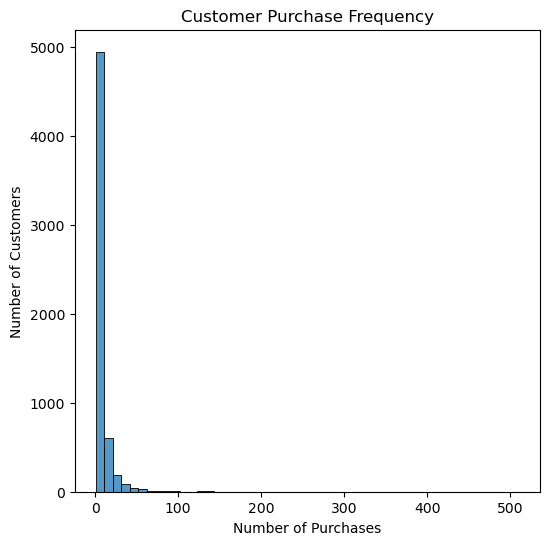

In [5]:
# 고객별 구매 횟수 집계
customer_purchase_counts = df.groupby('Customer ID')['Invoice'].nunique()

# 2회 이상 구매한 고객 수 확인
repeat_customers = customer_purchase_counts[customer_purchase_counts > 1].count()
all_customers = customer_purchase_counts.count()
repeat_rate = (repeat_customers / all_customers) * 100

print(f"반복 구매 고객 비율: {repeat_rate:.2f}%")

# 시각화
plt.figure(figsize=(6, 6))
sns.histplot(customer_purchase_counts, bins=50, kde=False)
plt.title("Customer Purchase Frequency")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

### 이탈 고객 분석

In [6]:
# 고객별 마지막 구매일
last_purchase = df.groupby('Customer ID')['InvoiceDate'].max()

# 이탈 기준일 설정 (예: 2021년 1월 1일)
cutoff_date = pd.to_datetime('2021-01-01')

# 이탈 고객 수 계산
churned_customers = last_purchase[last_purchase < cutoff_date].count()
active_customers = last_purchase[last_purchase >= cutoff_date].count()

print(f"이탈 고객 수: {churned_customers}")
print(f"활동 중인 고객 수: {active_customers}")

이탈 고객 수: 5942
활동 중인 고객 수: 0


### 회원/비회원 구매 분석

회원 매출: 16648292.388
비회원 매출: 2638958.18


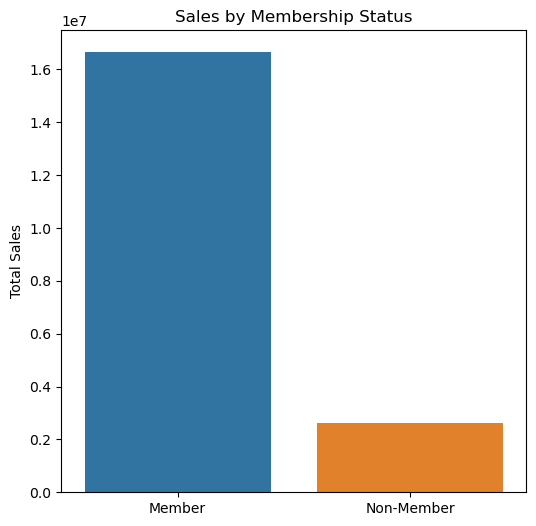

In [9]:
# 회원/비회원 구분
df['is_member'] = df['Customer ID'].notnull()

# 회원/비회원 구매 분석
member_sales = df[df['is_member'] == True]['TotalPrice'].sum()
non_member_sales = df[df['is_member'] == False]['TotalPrice'].sum()

print(f"회원 매출: {member_sales}")
print(f"비회원 매출: {non_member_sales}")

# 시각화
plt.figure(figsize=(6, 6))
sns.barplot(x=['Member', 'Non-Member'], y=[member_sales, non_member_sales])
plt.title("Sales by Membership Status")
plt.ylabel("Total Sales")
plt.show()

### RFM 분석

           Recency    Frequency       Monetary
count  5942.000000  5942.000000    5942.000000
mean    202.908617     7.552339    2801.799459
std     211.857936    15.972262   13973.922553
min       1.000000     1.000000  -25111.090000
25%      25.000000     2.000000     325.097500
50%      96.000000     4.000000     843.970000
75%     381.000000     8.000000    2182.005000
max     739.000000   510.000000  598215.220000


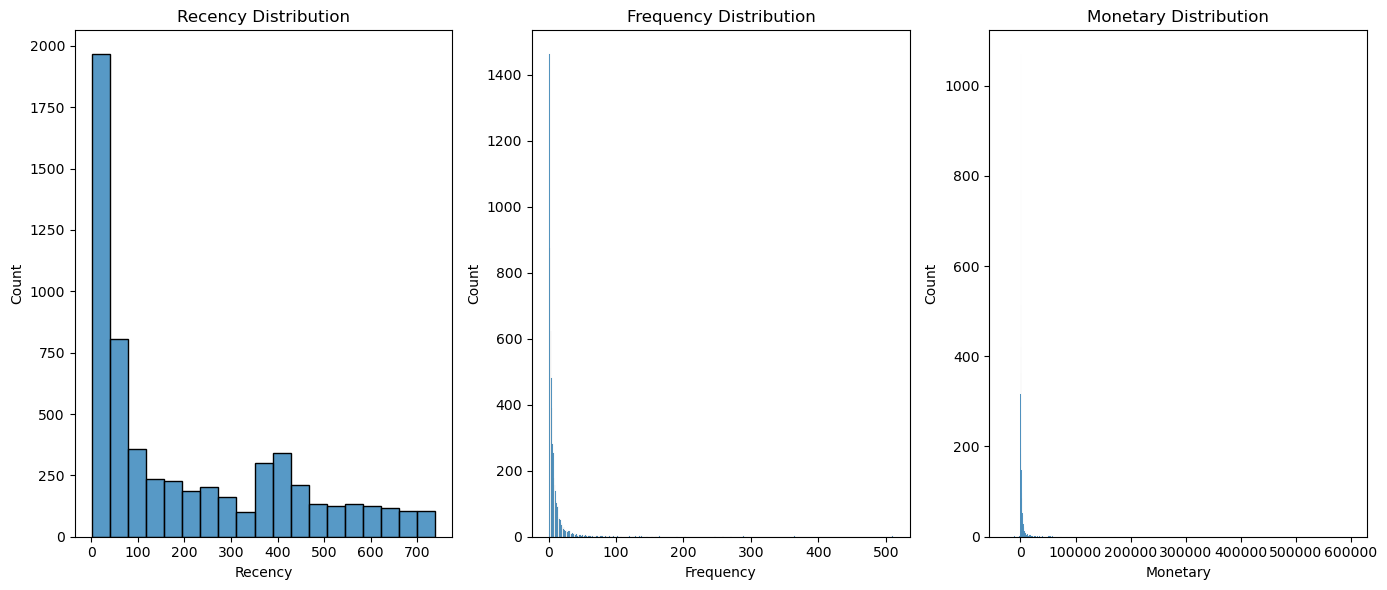

In [10]:
# 현재 날짜 설정
current_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# 고객별 RFM 계산
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

# RFM 분포 확인
print(rfm.describe())

# 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=False)
plt.title("Recency Distribution")
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=False)
plt.title("Frequency Distribution")
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=False)
plt.title("Monetary Distribution")
plt.tight_layout()
plt.show()

### 코호트 분석

<Axes: title={'center': 'Cohort Analysis - Retension Rate'}, xlabel='CohortIndex', ylabel='CohortMonth'>

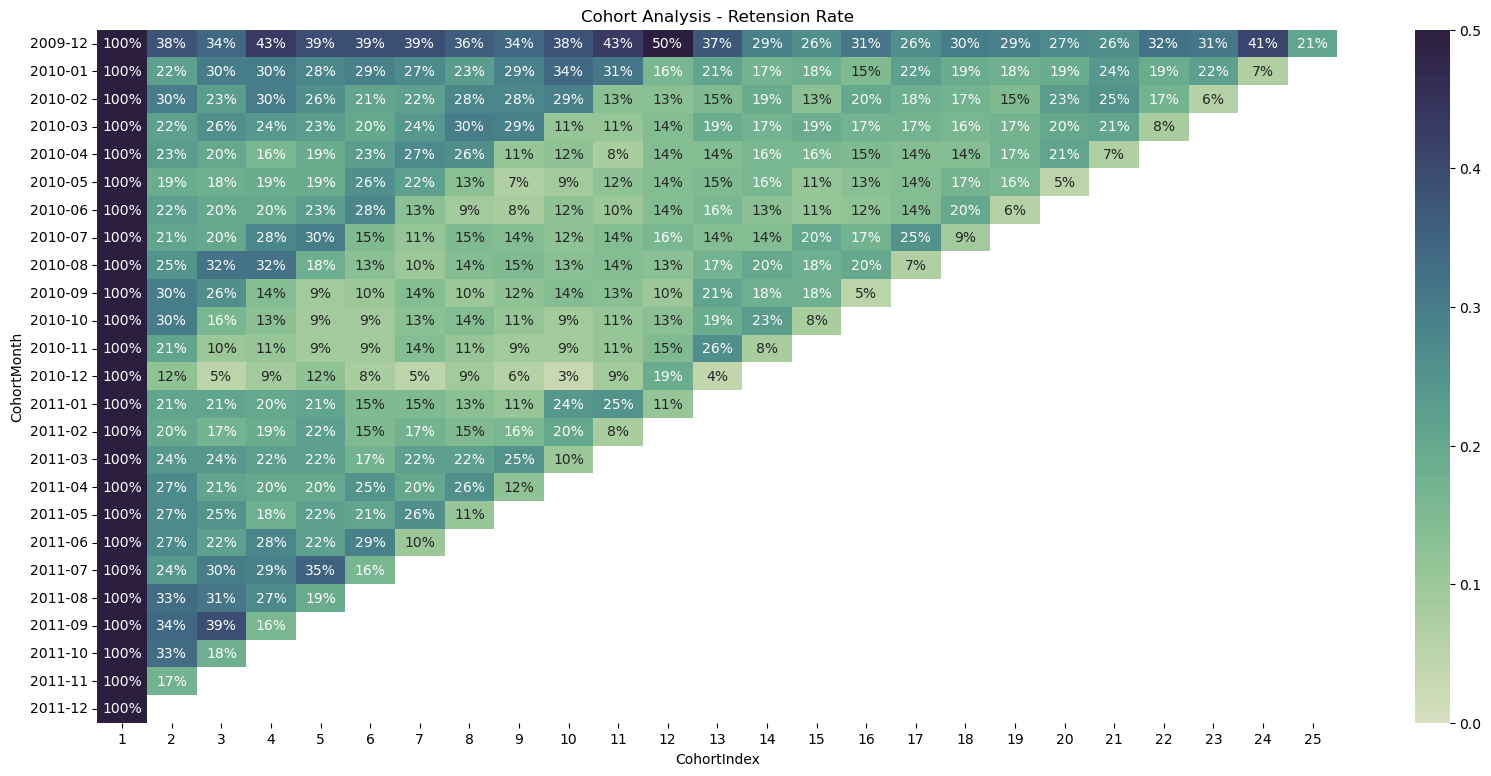

In [16]:
# InvoiceMonth 변수 생성
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# CohortMonth 변수 생성
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

# 코호트 인덱스 생성
invoce_year = df['InvoiceMonth'].dt.year
invoce_month = df['InvoiceMonth'].dt.month

cohort_year = df['CohortMonth'].dt.year
cohort_month = df['CohortMonth'].dt.month

year_diff = invoce_year - cohort_year
month_diff = invoce_month - cohort_month

# 1부터 코호트 인덱스 생성
df['CohortIndex'] = year_diff * 12 + month_diff + 1

# 각 코호트에서 고유한 고객을 계산
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()

# 코호트 데이터 피벗
cohort_count_customer = cohort_data.pivot(index='CohortMonth',
                                          columns='CohortIndex',
                                          values='Customer ID'
                                         )

# 각 코호트의 고객 수를 각 코호트의 고객 유지율로 전환

# 각 코호트의 첫 번째 달 고객 수
cohort_size = cohort_count_customer.iloc[:,0]

# 고객 수를 첫 번째 달 고객 수로 나누어 유지율 계산
retention = cohort_count_customer.divide(cohort_size, axis=0).round(2)

plt.figure(figsize=(20,9))
plt.title('Cohort Analysis - Retension Rate')
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
           )

### AARRR

Acquisition: 5942
Activation: 5942
Retention: 4481
Revenue: 19287250.56799999


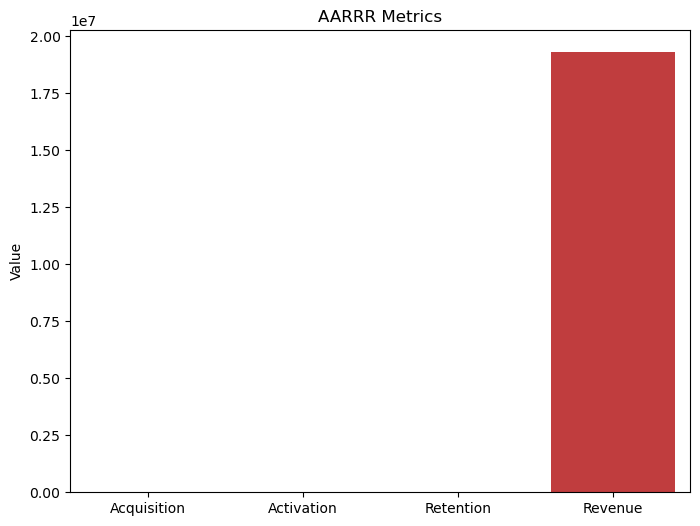

In [12]:
# Acquisition: 고객 수
acquisition = df['Customer ID'].nunique()

# Activation: 첫 구매 고객
first_purchase = df.groupby('Customer ID')['InvoiceDate'].min()
activated_customers = first_purchase[first_purchase < cutoff_date].count()

# Retention: 반복 구매 고객
retained_customers = customer_purchase_counts[customer_purchase_counts > 1].count()

# Revenue: 총 매출
total_revenue = df['TotalPrice'].sum()

# Referral: 추천 데이터가 없다면 건너뜀 (이 데이터셋에는 관련 정보 없음)

print(f"Acquisition: {acquisition}")
print(f"Activation: {activated_customers}")
print(f"Retention: {retained_customers}")
print(f"Revenue: {total_revenue}")

# 간단한 AARRR 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=['Acquisition', 'Activation', 'Retention', 'Revenue'], y=[acquisition, activated_customers, retained_customers, total_revenue])
plt.title("AARRR Metrics")
plt.ylabel("Value")
plt.show()